In [1]:
!pip install -q kaggle
!pip install transformers
!pip install unidecode
!pip install torch
!pip install tqdm
!pip install transformers

     |████████████████████████████████| 2.8 MB 7.1 MB/s 
     |████████████████████████████████| 895 kB 61.9 MB/s 
     |████████████████████████████████| 3.3 MB 59.7 MB/s 
     |████████████████████████████████| 636 kB 67.8 MB/s 
     |████████████████████████████████| 50 kB 9.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 241 kB 7.5 MB/s 


In [2]:
from google.colab import files
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gabib3b","key":"817d7e169db4cbef867b22907320144c"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

  0% 0.00/1.46M [00:00<?, ?B/s]
100% 1.46M/1.46M [00:00<00:00, 102MB/s]
  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 93.2MB/s]
 64% 15.0M/23.4M [00:00<00:00, 49.1MB/s]
100% 23.4M/23.4M [00:00<00:00, 78.2MB/s]
 84% 22.0M/26.3M [00:00<00:00, 17.6MB/s]
100% 26.3M/26.3M [00:00<00:00, 48.9MB/s]


In [5]:
! ls  

kaggle.json  sample_submission.csv.zip	test_labels.csv.zip
sample_data  test.csv.zip		train.csv.zip


In [6]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [7]:
!ls

kaggle.json  sample_submission.csv.zip	test_labels.csv.zip  train.csv.zip
sample_data  test.csv.zip		train.csv


In [8]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer
import string
import seaborn as sns

In [9]:
df = pd.read_csv("train.csv")[['id', 'comment_text', 'toxic']].sample(1000)

In [10]:
df.sample(3)

,id,comment_text,toxic
116596,6f4cc1bf5e387c24,"""==Sockpuppetry case==\n \nYou have been accus...",0
46508,7c3f29d1f316feba,Tkorrovi has put a number of diffs in his requ...,0
114099,627196be48c983b7,"""\nWell, first off, welcome to Wikipedia. As f...",0


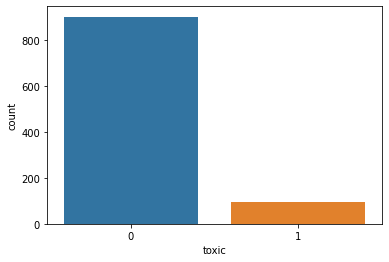

In [11]:
ax = sns.countplot(x="toxic", data=df)

In [12]:
df.rename(columns={'toxic': 'target'}, inplace = True)

train_df, validation_df = train_test_split(df, test_size = 0.2)
train_df.shape[0], validation_df.shape[0]

(800, 200)

In [13]:
# from transformers import BertTokenizer, BertModel
# import torch 
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# MAX_NUMBER_OF_WORDS_IN_SENTENSE = 512
# CLS = "[CLS] "
# SEP = " [SEP]"
# model = BertModel.from_pretrained('bert-base-uncased',
#                                   output_hidden_states = True)

# model.eval()

# def get_text_hidden_states(text: str):

#   marked_text = "[CLS] " + text + " [SEP]"
#   tokenized_text = tokenizer.tokenize(marked_text)[0: 512]
#   indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
#   segments_ids = [1] * len(tokenized_text)
#   tokens_tensor = torch.tensor([indexed_tokens])
#   segments_tensors = torch.tensor([segments_ids])
#   with torch.no_grad():

#     outputs = model(tokens_tensor, segments_tensors)
#     hidden_states = outputs[2]
    
#     return [torch.mean(hs, dim=1) for hs in hidden_states]
    





Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#train_df[['comment_text_tokens_ids', 'comment_text_segments_ids']] = train_df['comment_text'].progress_apply(text_to_tokens_ids)

100%|██████████| 800/800 [00:01<00:00, 513.25it/s]
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [14]:
# text = "he went home"
# marked_text = CLS + text + SEP
# tokenized_text = tokenizer.tokenize(marked_text)[0: MAX_NUMBER_OF_WORDS_IN_SENTENSE]
# indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# mask1 = [1] * len(indexed_tokens) + [0] * 5
# indexed_tokens1= indexed_tokens + [0] * 5

# mask2 = [1] * len(indexed_tokens[0:3]) + [0] * 7
# indexed_tokens2= indexed_tokens[0:3] + [0] * 7
# len(indexed_tokens2), len(indexed_tokens1)

# in1 = torch.tensor([indexed_tokens1, indexed_tokens2])
# # segments_ids = [1] * len(indexed_tokens)
# # segments_tensors = torch.tensor([segments_ids])
# mask = torch.tensor([mask1, mask2])
# outputs = model(in1, attention_mask = mask)

# hidden_states = outputs[2]

# hidden_states[-1].shape

# ss = torch.IntTensor([5,3])

# pp = hidden_states[-1][:, :ss, :]


# #torch.mean(hidden_states[-1])
# #-0.0128 
# # hidden_states[-1][0][-2].shape, len(indexed_tokens), mask

In [13]:
from abc import ABC, abstractmethod
from typing import List 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support

class BaseClassifier(ABC):
  
  def __init__(self, bert_model, tokenizer):
    self._bert_model = bert_model
    self._bert_model.eval()
    self._tokenizer = tokenizer

  @abstractmethod
  def fit(self, df: pd.DataFrame):
    pass 

  @abstractmethod
  def predict(self, df: pd.DataFrame):
    pass 
  
  def text_to_tokens_ids(self, text):

    marked_text = CLS + text + SEP
    tokenized_text = self._tokenizer.tokenize(marked_text)[0: MAX_NUMBER_OF_WORDS_IN_SENTENSE]
    indexed_tokens = self._tokenizer.convert_tokens_to_ids(tokenized_text)
    #segments_ids = [1] * len(tokenized_text)

    return indexed_tokens

  def text_to_sentense_embeddingds(self, text: str, embeddings_layer: int):
    indexed_tokens = self.text_to_tokens_ids(text)
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_ids = [1] * len(indexed_tokens)
    segments_tensors = torch.tensor([segments_ids])

    with torch.no_grad():
      outputs = self._bert_model(tokens_tensor, segments_tensors)
      hidden_states = outputs[2]
      
    return torch.mean(hidden_states[embeddings_layer], dim=1).numpy().flatten() if embeddings_layer is not None else hidden_states
  
  def evaluate(self, df):
    predictions = self.predict(df)
    targets = df['target'].tolist()

    precision, recall, fscore, _ = precision_recall_fscore_support(targets, predictions, average='binary')

    return pd.DataFrame([(precision, recall, fscore)], columns = ['precision','recall', 'fscore'])

  
class NearestNeiborClassifier(BaseClassifier):
  def __init__(self, bert_model, tokenizer, embeddings_layer, n_neighbors):
    BaseClassifier.__init__(self, bert_model, tokenizer)
    self._embeddings_layer = embeddings_layer
    self._n_neighbors = n_neighbors
    self._model = None

  def fit(self, df: pd.DataFrame):
    
    X = df['comment_text'].progress_apply(lambda text: self.text_to_sentense_embeddingds(text, self._embeddings_layer)).tolist()
    y = df['target'].tolist()

    self._model = KNeighborsClassifier(n_neighbors = self._n_neighbors)
    self._model.fit(X, y)

  def predict(self, df):
    X = df['comment_text'].progress_apply(lambda text: self.text_to_sentense_embeddingds(text, self._embeddings_layer)).tolist()
    
    return self._model.predict(X)
  

class TorchClassifier(BaseClassifier):
  def __init__(self, bert_model, tokenizer, embeddings_layer, n_neighbors):
    BaseClassifier.__init__(self, bert_model, tokenizer)
    self._embeddings_layer = embeddings_layer
    self._n_neighbors = n_neighbors
    self._model = None

  def fit(self, df: pd.DataFrame):
    
    X = df['comment_text'].progress_apply(lambda text: self.text_to_sentense_embeddingds(text, self._embeddings_layer)).tolist()
    y = df['target'].tolist()

    self._model = KNeighborsClassifier(n_neighbors = self._n_neighbors)
    self._model.fit(X, y)

  def predict(self, df):
    X = df['comment_text'].progress_apply(lambda text: self.text_to_sentense_embeddingds(text, self._embeddings_layer)).tolist()
    
    return self._model.predict(X)
  
  




In [ ]:
# precision_recall_fscore_support([1,0,1,0], [1,1,1,1], average='binary')

(0.5, 1.0, 0.6666666666666666, None)

In [15]:
from transformers import BertTokenizer, BertModel

bert = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True)

bert.eval()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [20]:
CLS = "[CLS] "
SEP = " [SEP]"
MAX_NUMBER_OF_WORDS_IN_SENTENSE = 512

In [ ]:
import torch

nn = NearestNeiborClassifier(bert, tokenizer, -1, 3)
nn.fit(train_df)
nn.evaluate(validation_df)

  4%|▍         | 31/800 [00:07<01:58,  6.51it/s]

In [29]:
from torch.utils.data import TensorDataset, RandomSampler, Dataset

class DatasetLoader(Dataset):

    def __init__(self, df):
        self._df = df

    def __len__(self):
        return len(self._df)

    def __getitem__(self, idx):
        row = self._df.iloc[idx]


        return row['id'], row['comment_text_tokens_ids'], row['target']

In [31]:
def group_rows(rows):

    max_length = np.max([len(tokenes_ids) for _, tokenes_ids, _ in rows])

    ids = [id for id, _, _ in rows]

    tokenes_ids = torch.LongTensor([np.concatenate([tokenes_ids, np.repeat(tokenizer.pad_token_id, max_length - len(tokenes_ids))])
                   for id, tokenes_ids, target in rows])


    targets = [target for _, _, target in rows]

    masks = torch.LongTensor([np.concatenate([np.repeat(1, len(tokenes_ids)), np.repeat(0, max_length - len(tokenes_ids))])
          for _, tokenes_ids, _ in rows])
    
    return ids, tokenes_ids, masks, torch.FloatTensor(targets).reshape(-1, 1)


In [33]:
BATCH_SIZE = 5
train_dataset_loader  = DatasetLoader(df)
sampler = RandomSampler(train_dataset_loader)

train_data_loader = torch.utils.data.DataLoader(train_dataset_loader,
                                                 batch_size=BATCH_SIZE, shuffle=False,
                                                 num_workers=4,drop_last=False,
                                                sampler = sampler,
                                                 collate_fn=group_rows)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [110]:
from torch import nn, utils

class RelevanceModel(nn.Module):

    def __init__(self, bert, num_of_classes, embeddings_layer):
        super(RelevanceModel, self).__init__()

        self._embeddings_layer = embeddings_layer
        self._bert = bert

        self._bert.eval()

        for param in self._bert.parameters():
            param.requires_grad = False

        self.af1 = nn.LeakyReLU()
        self.fc1 = nn.Linear(768, 1)


    def forward(self, tokens, attention_mask):
        hidden_states = self._bert(tokens, attention_mask)[2]


        sentense_embeddingds = torch.mean(hidden_states[self._embeddings_layer], dim=1)

        out = self.af1(sentense_embeddingds)

        out = self.fc1(out)

        return out

    def reset_parameters(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

In [111]:
from sklearn.utils.class_weight import compute_class_weight
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [142]:
class DeepModel(BaseClassifier):


    def __init__(self, bert, tokenizer, num_of_classes, embeddings_layer, batch_size):
        BaseClassifier.__init__(self, bert, tokenizer)
        bert.to(device)
        self._model  = RelevanceModel(bert, num_of_classes, embeddings_layer)
        self._model.to(device)
        self._batch_size = batch_size

    def _calc_positive_weight(self, df: pd.DataFrame) -> float:
      weights = compute_class_weight('balanced', np.unique(train_df.target),  train_df.target)
      pos_weight = weights[1]/weights[0]
      return pos_weight   

    def fit(self, df: pd.DataFrame):

        positive_weight = self._calc_positive_weight(df)

        pos_weights_tensor = torch.Tensor([positive_weight])
       
        df['comment_text_tokens_ids'] = df['comment_text'].progress_apply(lambda text: self.text_to_tokens_ids(text))

        LR = 0.001
        optimizer = torch.optim.Adam(self._model.parameters(), lr=LR)
        train_dataset = DatasetLoader(df)
        sampler = RandomSampler(train_dataset)

        train_data_loader = torch.utils.data.DataLoader(train_dataset,
                                                        batch_size=self._batch_size,
                                                        shuffle=False,
                                                        num_workers=4,
                                                        drop_last=False,
                                                        sampler=sampler,
                                                        collate_fn=group_rows)

        loss_fn  = nn.BCEWithLogitsLoss(pos_weight = pos_weights_tensor).to(device)
        #loss_fn  = nn.BCEWithLogitsLoss().to(device)

        for batch in range(1000):
          total_loss = 0.0
          for ids, tokends_ids, attention_mask, targets in train_data_loader:
                
              tokends_ids = tokends_ids.to(device)
              attention_mask = attention_mask.to(device)
              targets = targets.to(device)

              optimizer.zero_grad()

              output = self._model(tokends_ids, attention_mask)

              # print(output.device)
              # print(targets.device)

              loss = loss_fn(output, targets)
    
              loss.backward()
              optimizer.step()

              total_loss += loss.item()
            
          print('batch {} loss {}'.format(batch, loss))

    def predict(self, df: pd.DataFrame):
        pass

In [143]:
dm = DeepModel(bert, tokenizer, 2, -1, 3 )

In [144]:

xx = train_df.sample(100)
dm.fit(xxx)
# # xx['comment_text_tokens_ids'] = xx['comment_text'].progress_apply(lambda text: dm.text_to_tokens_ids(text))
# # train_dataset = DatasetLoader(xx)
# # sampler = RandomSampler(train_dataset)

# # train_data_loader = torch.utils.data.DataLoader(train_dataset,
# #                                                         batch_size=3,
# #                                                         shuffle=False,
# #                                                         num_workers=4, drop_last=False,
# #                                                         sampler=sampler,
# #                                                         collate_fn=group_rows)


# # # for x in train_data_loader:
# # #   print(x)
# # #   break

# total_loss = 0.0 
# LR = 0.001
# optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# model = RelevanceModel(bert, 1, -1).to(device)
# loss_fn  = nn.BCEWithLogitsLoss().to(device)
# for ids, tokends_ids, attention_mask, targets in train_data_loader:
#   tokends_ids = tokends_ids.to(device)
#   attention_mask = attention_mask.to(device)
#   targets = targets.to(device)

#   optimizer.zero_grad()

#   output = model(tokends_ids, attention_mask)

#   loss = loss_fn(output, targets)

#   loss.backward()
#   optimizer.step()

#   total_loss += loss.item()




100%|██████████| 100/100 [00:00<00:00, 704.49it/s]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


batch 0 loss 0.3698037266731262
batch 1 loss 0.4290512800216675
batch 2 loss 0.44827210903167725
batch 3 loss 0.41652911901474
batch 4 loss 0.3976021409034729
batch 5 loss 0.25485754013061523
batch 6 loss 3.081465721130371
batch 7 loss 0.42394304275512695
batch 8 loss 0.5060089826583862
batch 9 loss 0.180253267288208
batch 10 loss 0.1408752202987671
batch 11 loss 0.19981849193572998
batch 12 loss 0.26425766944885254
batch 13 loss 0.14207005500793457
batch 14 loss 0.2958998680114746
batch 15 loss 0.3813920021057129
batch 16 loss 0.23926806449890137
batch 17 loss 0.09234237670898438
batch 18 loss 3.418997049331665
batch 19 loss 0.1646503210067749
batch 20 loss 0.3867436647415161
batch 21 loss 0.07764840126037598
batch 22 loss 0.5289292931556702
batch 23 loss 0.041028499603271484
batch 24 loss 0.06550168991088867
batch 25 loss 0.18632471561431885
batch 26 loss 0.16399717330932617
batch 27 loss 0.42012983560562134
batch 28 loss 0.08543801307678223
batch 29 loss 0.05648660659790039
batch 30

KeyboardInterrupt: ignored